# Import necessary libraries

In [1]:
import torch

# Check if CUDA (GPU support) is available
from pytorch_tabnet.tab_model import TabNetRegressor

# Set the device name based on CUDA availability
model = TabNetRegressor(device_name='cuda')  # Use 'cuda' if you have a GPU and CUDA set up


# model = TabNetRegressor().to(device)
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
np.random.seed(0)

import seaborn as sb
import matplotlib.pyplot as plt 
sb.set() 

import os
import wget
from pathlib import Path

c:\Users\User\OneDrive - Nanyang Technological University\Desktop\Y2S2\SC1015 Data Science\Project\SC1015_Mini_Proj\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


# Load necessary data set

In [4]:
data_three = pd.read_csv("data/raw_data/jan2015toDec2016.csv")
data_four = pd.read_csv("data/raw_data/jan2017upwards.csv")

data_three = data_three.drop(columns=["block", "street_name"])
data_four = data_four.drop(columns=["block", "street_name"])

combined_data = pd.concat([data_three, data_four], ignore_index=True)

sorted_combined_data = combined_data.sort_values(by='month', ascending=True)

sorted_combined_data['remaining_lease'] = sorted_combined_data['remaining_lease'].fillna('NULL')

sorted_combined_data

,month,town,flat_type,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2015-01,ANG MO KIO,3 ROOM,07 TO 09,60.0,Improved,1986,70,255000.0
837,2015-01,SEMBAWANG,4 ROOM,01 TO 03,86.0,Model A2,2001,85,343000.0
836,2015-01,SEMBAWANG,4 ROOM,07 TO 09,90.0,Model A,2000,84,340000.0
835,2015-01,SEMBAWANG,4 ROOM,04 TO 06,90.0,Model A,2004,88,339000.0
834,2015-01,QUEENSTOWN,5 ROOM,19 TO 21,117.0,Improved,2012,96,950000.0
...,...,...,...,...,...,...,...,...,...
211434,2024-03,HOUGANG,4 ROOM,01 TO 03,105.0,Model A,1990,65 years 02 months,538888.0
211435,2024-03,HOUGANG,4 ROOM,10 TO 12,91.0,New Generation,1985,60 years 05 months,538000.0
211436,2024-03,HOUGANG,4 ROOM,07 TO 09,98.0,New Generation,1978,53 years 03 months,538000.0
211422,2024-03,HOUGANG,4 ROOM,04 TO 06,92.0,Model A,2019,94 years 07 months,573000.0


# Taking out useful CPI values

In [22]:
CPIData = pd.read_csv('data/raw_data/CPID.csv', header=None)
datetoextract = CPIData.iloc[0]
indextoextract = CPIData.iloc[67]
data = {'Period': datetoextract, 'CPIvalue': indextoextract}
AccomsCPI = pd.DataFrame(data)
AccomsCPI = AccomsCPI.drop(AccomsCPI.index[0])

AccomsCPI[['Year', 'Month']] = AccomsCPI['Period'].str.extract('(\d{4})(\w{3})', expand=True)
AccomsCPI['Date'] = pd.to_datetime(AccomsCPI['Year'] + AccomsCPI['Month'], format='%Y%b')
AccomsCPI = AccomsCPI.sort_values(['Year', 'Date'], ascending=[False, False])
AccomsCPI = AccomsCPI[AccomsCPI['Date'] >= '2015-01-01']
AccomsCPI = AccomsCPI.drop(['Year', 'Month', 'Date'], axis=1)
AccomsCPI.loc[AccomsCPI['CPIvalue'] == 'na', 'CPIvalue'] = 0
AccomsCPI = AccomsCPI.reset_index(drop=True)
AccomsCPI['CPIvalue'] = AccomsCPI['CPIvalue'].astype(float)
AccomsCPI['Period'] = pd.to_datetime(AccomsCPI['Period'], format='%Y%b')
AccomsCPI['Period'] = AccomsCPI['Period'].dt.to_period('M')
AccomsCPI['Period'] = AccomsCPI['Period'].astype(str)
AccomsCPI

,Period,CPIvalue
0,2024-01,-2.7
1,2023-12,0.2
2,2023-11,1.9
3,2023-10,-1.4
4,2023-09,0.3
...,...,...
104,2015-05,2.3
105,2015-04,-2.7
106,2015-03,-0.2
107,2015-02,-0.2


# Creating CPI adjustment values for selected period

In [24]:
AccomsCPI['AdjustmentValue'] = 1.0

# Loop to calculate AdjustmentValue
for idx, cpi in enumerate(AccomsCPI['CPIvalue']):
    if idx != 0:
        AccomsCPI.loc[idx, 'AdjustmentValue'] = AccomsCPI.loc[idx - 1, 'AdjustmentValue'] * (1 + (AccomsCPI.loc[idx - 1, 'CPIvalue'] / 100))

# Corrected datetime conversion
AccomsCPI['Period'] = pd.to_datetime(AccomsCPI['Period'], format='%Y-%m')

# Converting to Period type
AccomsCPI['Period'] = AccomsCPI['Period'].dt.to_period('M')

# Converting Period to string
AccomsCPI['Period'] = AccomsCPI['Period'].astype(str)

# Printing the DataFrame to check the results
print(AccomsCPI)

      Period  CPIvalue  AdjustmentValue
0    2024-01      -2.7         1.000000
1    2023-12       0.2         0.973000
2    2023-11       1.9         0.974946
3    2023-10      -1.4         0.993470
4    2023-09       0.3         0.979561
..       ...       ...              ...
104  2015-05       2.3         0.969632
105  2015-04      -2.7         0.991934
106  2015-03      -0.2         0.965152
107  2015-02      -0.2         0.963221
108  2015-01      -0.2         0.961295

[109 rows x 3 columns]


# Visualising how price has changed since 2015

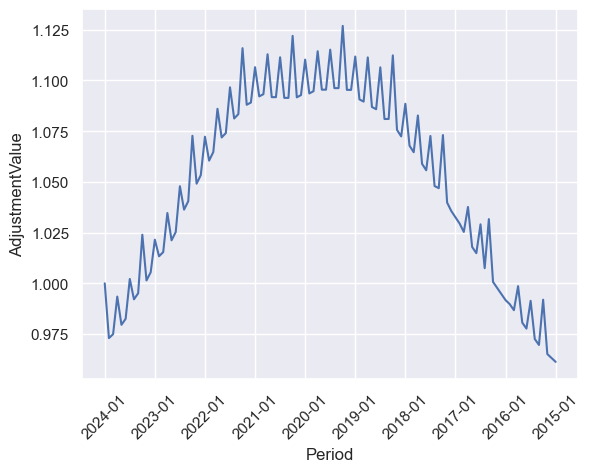

In [25]:
ax = sb.lineplot(data=AccomsCPI, x='Period', y='AdjustmentValue' )
ax.set_xticks(range(0, len(AccomsCPI), 12))  
ax.set_xticklabels([AccomsCPI['Period'][i] for i in range(0, len(AccomsCPI), 12)], rotation=45) 


plt.show()

# Adjusting resale price to current value 

In [114]:
merged_data = pd.merge(sorted_combined_data, AccomsCPI, left_on='month', right_on='Period', how='left')

# Fill missing AdjustmentValue with 1.0
merged_data['AdjustmentValue'] = merged_data['AdjustmentValue'].fillna(1.0)

# Adjust the sale price to today's cost
merged_data['resale_price_adjusted'] = merged_data['resale_price'] * merged_data['AdjustmentValue']

# Drop the unnecessary columns after adjustment
columns_to_drop = ['Period', 'CPIvalue']
merged_data.drop(columns=[col for col in columns_to_drop if col in merged_data.columns], axis=1, inplace=True)

#changing "x" years and "y" months into x+(y/12) years ---> eg 4years 6 months = 4.5years 
merged_data['years'] = merged_data['remaining_lease'].str.extract(r'(\d+) years').astype(float)
merged_data['months'] = merged_data['remaining_lease'].str.extract(r'(\d+) months').astype(float)
merged_data['remaining_lease'] = merged_data['years'] + merged_data['months'] / 12
merged_data = merged_data.drop(['years', 'months'], axis=1)

#changing 7 to 9 floor into average of 8th floor
merged_data['lower_storey'] = merged_data['storey_range'].str.extract(r'(\d+) TO (\d+)').astype(float).iloc[:,0]
merged_data['upper_storey'] = merged_data['storey_range'].str.extract(r'(\d+) TO (\d+)').astype(float).iloc[:,1]
merged_data['average_storey'] = (merged_data['lower_storey'] + merged_data['upper_storey']) / 2
columns_to_drop_final = ['lower_storey', 'upper_storey', 'storey_range', 'resale_price', 'AdjustmentValue', 'remaining_lease', 'month']
merged_data = merged_data.drop(columns=[col for col in columns_to_drop_final if col in merged_data.columns], axis=1)

merged_data.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212148 entries, 0 to 212147
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   town                   212148 non-null  object 
 1   flat_type              212148 non-null  object 
 2   floor_area_sqm         212148 non-null  float64
 3   flat_model             212148 non-null  object 
 4   lease_commence_date    212148 non-null  int64  
 5   resale_price_adjusted  212148 non-null  float64
 6   average_storey         212148 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 11.3+ MB


In [115]:
merged_data

,town,flat_type,floor_area_sqm,flat_model,lease_commence_date,resale_price_adjusted,average_storey
0,ANG MO KIO,3 ROOM,60.0,Improved,1986,245130.210054,8.0
1,SEMBAWANG,4 ROOM,86.0,Model A2,2001,329724.164896,2.0
2,SEMBAWANG,4 ROOM,90.0,Model A,2000,326840.280072,8.0
3,SEMBAWANG,4 ROOM,90.0,Model A,2004,325878.985130,5.0
4,QUEENSTOWN,5 ROOM,117.0,Improved,2012,913230.194318,20.0
...,...,...,...,...,...,...,...
212143,HOUGANG,4 ROOM,105.0,Model A,1990,538888.000000,2.0
212144,HOUGANG,4 ROOM,91.0,New Generation,1985,538000.000000,11.0
212145,HOUGANG,4 ROOM,98.0,New Generation,1978,538000.000000,8.0
212146,HOUGANG,4 ROOM,92.0,Model A,2019,573000.000000,5.0


# See how different categorical data influence resale price (adjusted)

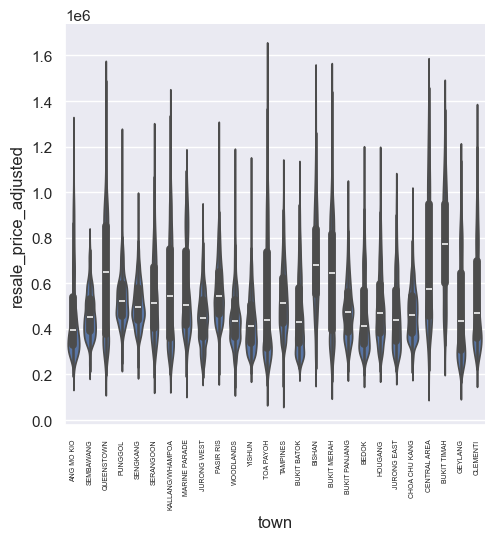

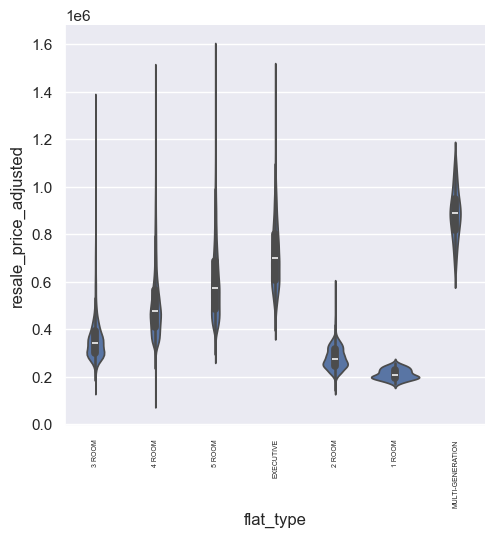

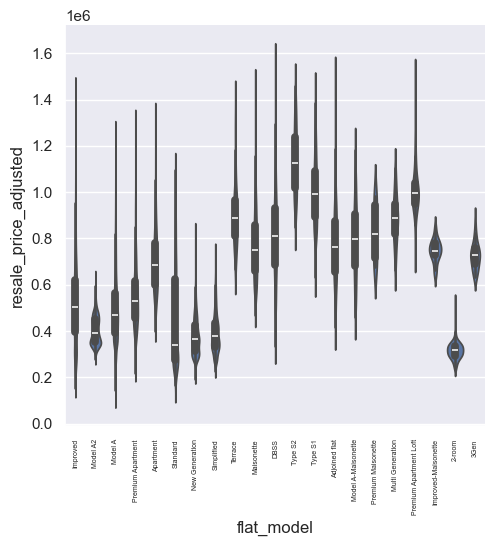

In [116]:
categoricaldata = pd.DataFrame(merged_data[['town', 'flat_type', 'flat_model', 'resale_price_adjusted']])
for var in ['town', 'flat_type', 'flat_model']:
    plot = sb.catplot(data=categoricaldata, x=var, y='resale_price_adjusted', kind = 'violin')
    plot.set_xticklabels(fontsize=5,rotation = 90)  


# Encode categorical data from 0 to n-1 based on increasing resale price median 
# Plot heat map to visalise which factors has stronger correlation with resale price 

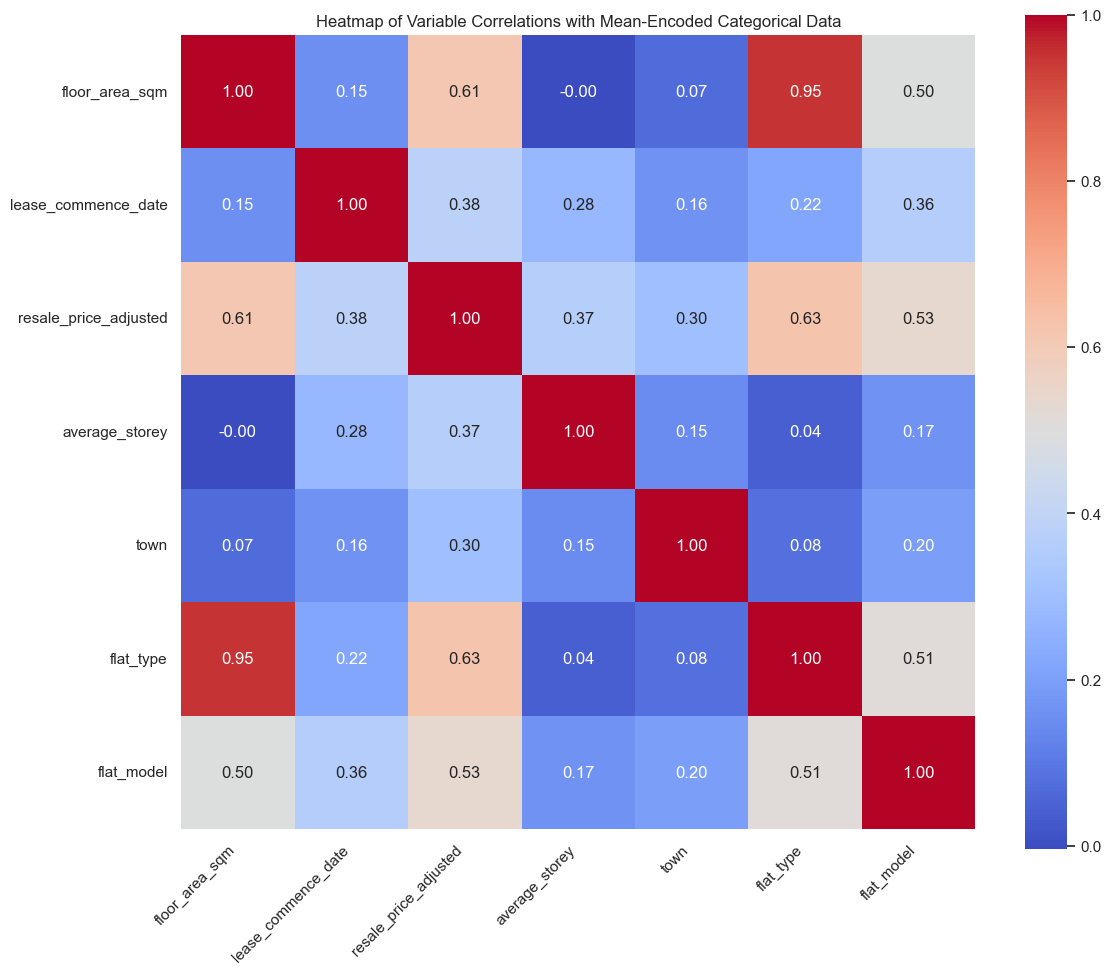

In [169]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

encoding_mappings = {}

# Assuming 'merged_data' is your DataFrame
# Let's separate the numerical and categorical columns
numerical_data = merged_data.select_dtypes(include=['float64', 'int64'])
categorical_columns = merged_data.select_dtypes(include=['object']).columns.tolist()

# Calculate the mean resale_price_adjusted for each category within the categorical variables and replace the categorical variable
encoded_data = merged_data.copy()
for column in categorical_columns:
    # Calculate the mean resale_price_adjusted for each category
    mean_prices = merged_data.groupby(column)['resale_price_adjusted'].median().sort_values()
    # Create a rank for each category based on resale price mean
    rank = {category: rank for rank, category in enumerate(mean_prices.index, 0)}
    
    encoding_mappings[column] = rank

    # Map the rank to the original data
    encoded_data[column] = merged_data[column].map(rank)


# Combine the numerical data with the mean-encoded categorical data
final_data = pd.concat([numerical_data, encoded_data[categorical_columns]], axis=1)

# Calculate the correlation matrix for the combined dataset
correlation_matrix = final_data.corr()

# Plot the heatmap matrix with annotations
plt.figure(figsize=(12, 10))  # Adjust the size as needed
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Heatmap of Variable Correlations with Mean-Encoded Categorical Data')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)  # Ensure y-axis labels are horizontal for better readability
plt.tight_layout()  # Adjust the layout so everything fits without overlap
plt.show()

# Visualising encoded categorical data

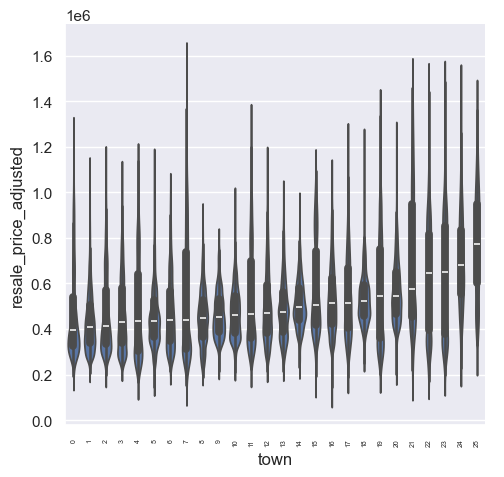

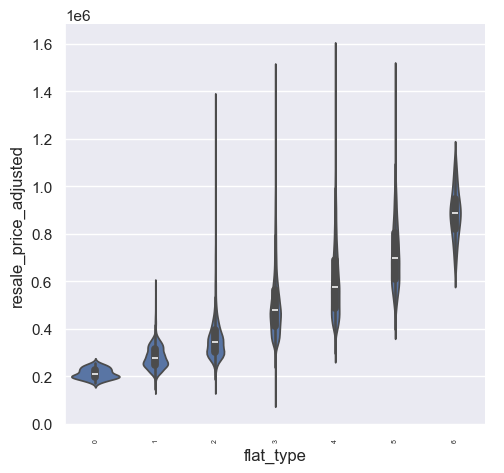

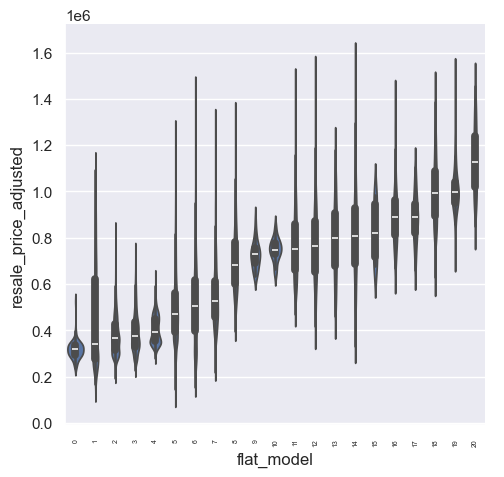

In [118]:
categoricaldata = pd.DataFrame(final_data[['town', 'flat_type', 'flat_model', 'resale_price_adjusted']])
for var in ['town', 'flat_type', 'flat_model']:
    plot = sb.catplot(data=categoricaldata, x=var, y='resale_price_adjusted', kind = 'violin')
    plot.set_xticklabels(fontsize=5,rotation = 90)  


In [216]:
categoricaldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212148 entries, 0 to 212147
Data columns (total 4 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   town                   212148 non-null  int64  
 1   flat_type              212148 non-null  int64  
 2   flat_model             212148 non-null  int64  
 3   resale_price_adjusted  212148 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 6.5 MB


In [221]:
def encode_new_input(new_input, encoding_mappings):
# If new_input is a dictionary, convert it to a DataFrame
    if isinstance(new_input, dict):
        new_input = pd.DataFrame([new_input])
    
    # If new_input is a list of dictionaries, convert it to a DataFrame
    elif isinstance(new_input, list):
        new_input = pd.DataFrame(new_input)

    # Ensure that new_input is a DataFrame at this point
    if not isinstance(new_input, pd.DataFrame):
        raise ValueError("new_input must be a pandas DataFrame, a dictionary, or a list of dictionaries.")    
    new_input_encoded = new_input.copy()
    for column, mapping in encoding_mappings.items():
        if column in new_input.columns:
            # Apply the mapping to the column
            new_input_encoded[column] = new_input[column].map(mapping)
            # Fill in NaN values if the category was not seen during training
            if new_input_encoded[column].isna().any():
                unknown_rank = np.median(list(mapping.values()))
                # Use direct assignment instead of inplace=True
                new_input_encoded[column] = new_input_encoded[column].fillna(unknown_rank)
    
    return new_input_encoded

# Employing basic linearing regression model with the numerical data

Goodness of Fit of Model on Train Dataset:
Explained Variance (R^2): 0.6011242658741707
Mean Squared Error (MSE): 12047928487.676102

Goodness of Fit of Model on Test Dataset:
Explained Variance (R^2): 0.6001287182018655
Mean Squared Error (MSE): 12158983512.611301



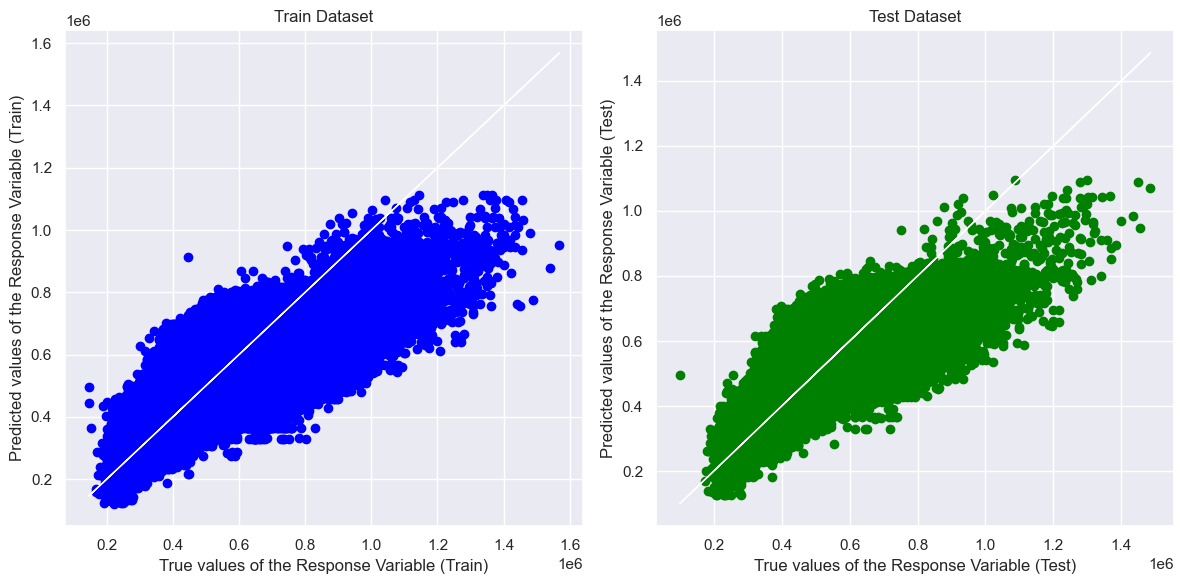

In [220]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


X = pd.concat([final_data[['floor_area_sqm', 'lease_commence_date', 'average_storey','town', 'flat_type', 'flat_model']]])
X.head(20)
y = final_data['resale_price_adjusted']
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Predictions
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Model Evaluation
print("Goodness of Fit of Model on Train Dataset:")
print("Explained Variance (R^2):", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE):", mean_squared_error(y_train, y_train_pred))
print()

print("Goodness of Fit of Model on Test Dataset:")
print("Explained Variance (R^2):", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_test_pred))
print()

# Plot the Predictions versus True values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, color="blue")
plt.plot(y_train, y_train, 'w-', linewidth=1)
plt.xlabel("True values of the Response Variable (Train)")
plt.ylabel("Predicted values of the Response Variable (Train)")
plt.title("Train Dataset")

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, color="green")
plt.plot(y_test, y_test, 'w-', linewidth=1)
plt.xlabel("True values of the Response Variable (Test)")
plt.ylabel("Predicted values of the Response Variable (Test)")
plt.title("Test Dataset")

plt.tight_layout()
plt.show()

In [227]:
new_sample = {
    'floor_area_sqm': 100,
    'lease_commence_date': 2020,
    'average_storey': 10,
    'town': 'ANG MO KIO',
    'flat_type': '5 ROOM',
    'flat_model': 'Simplified'
}

encoded_user_input_linreg = encode_new_input(new_sample, encoding_mappings)

encoded_user_input_array_linreg = encoded_user_input_linreg.to_numpy()

predicted_resale_value_linreg = linreg.predict(encoded_user_input_array_linreg)

print(f"Predicted Resale Value: {predicted_resale_value_linreg[0]}")

Predicted Resale Value: 519854.3094183635


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


# Load data and split

In [127]:
# Assuming 'encoded_data' is a preprocessed DataFrame where categorical columns are already encoded.
train = final_data
target = 'resale_price_adjusted'

# Randomly assign rows to train, valid, and test sets if not already done.
if 'Set' not in train.columns:
    train['Set'] = np.random.choice(["train", "valid", "test"], p=[.8, .1, .1], size=(train.shape[0],))

# Get indices for each set.
train_indices = train[train.Set == "train"].index
valid_indices = train[train.Set == "valid"].index
test_indices = train[train.Set == "test"].index

train.head(20)


,floor_area_sqm,lease_commence_date,resale_price_adjusted,average_storey,town,flat_type,flat_model,Set
0,60.0,1986,245130.210054,8.0,0,2,6,train
1,86.0,2001,329724.164896,2.0,9,3,4,train
2,90.0,2000,326840.280072,8.0,9,3,5,train
3,90.0,2004,325878.985130,5.0,9,3,5,train
4,117.0,2012,913230.194318,20.0,23,4,6,train
5,124.0,2012,793068.326644,5.0,23,4,6,train
6,110.0,2006,790953.477773,5.0,23,4,6,valid
7,111.0,2003,749810.054282,29.0,23,4,6,train
8,115.0,2000,720971.206040,2.0,23,4,6,test
9,90.0,2008,736351.925102,32.0,23,3,5,train


In [146]:
# Define features to exclude from the model and the categorical columns
unused_feat = ['Set']
categorical_columns = ['town', 'flat_type', 'flat_model']  # Based on provided snippet

# Create a list of features to be used for training
features = ['floor_area_sqm','lease_commence_date','average_storey','town','flat_type','flat_model'] 

# Identify the index positions of categorical features in the 'features' list
cat_idxs = [i for i, f in enumerate(features) if f in categorical_columns]

# Compute the cardinality (number of unique values) for each categorical feature
categorical_dims = {col: train[col].nunique() for col in categorical_columns}
cat_dims = [categorical_dims[f] for f in features if f in categorical_columns]


# Define the embedding sizes for categorical features
cat_emb_dim = [min(50, (dim + 1) // 2) for dim in cat_dims]

print(cat_idxs)
print(cat_dims)
print(cat_emb_dim)

[3, 4, 5]
[26, 7, 21]
[13, 4, 11]


In [155]:
# Initialize the TabNetRegressor with the defined categorical dimensions and embedding sizes
clf = TabNetRegressor(cat_dims=cat_dims, cat_emb_dim=cat_emb_dim, cat_idxs=cat_idxs)



c:\Users\User\OneDrive - Nanyang Technological University\Desktop\Y2S2\SC1015 Data Science\Project\SC1015_Mini_Proj\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [158]:
np.set_printoptions(suppress=True)

# Split the data into features and targets based on the indices
X_train = train.loc[train_indices, features].values
y_train = train.loc[train_indices, target].values.reshape(-1, 1)

X_valid = train.loc[valid_indices, features].values
y_valid = train.loc[valid_indices, target].values.reshape(-1, 1)

X_test = train.loc[test_indices, features].values
y_test = train.loc[test_indices, target].values.reshape(-1, 1)

y_train_log = np.log1p(y_train)  # Apply log transformation
y_valid_log = np.log1p(y_valid)
y_test_log = np.log1p(y_test)

print(X_valid[:5])  # Print the first 5 rows of X_train
print(y_valid[:5])



[[ 110. 2006.    5.   23.    4.    6.]
 [  96. 2000.    2.   23.    3.    5.]
 [ 137. 2001.   11.    9.    5.    7.]
 [ 110. 2001.    8.    9.    4.    6.]
 [ 100. 1999.   14.    9.    3.    5.]]
[[790953.47777312]
 [644067.61072921]
 [444118.26292074]
 [427776.24891716]
 [360485.60302008]]


In [161]:
# Fit the TabNetRegressor on the training data
max_epochs = 20
clf.fit(
    X_train, y_train_log,
    eval_set=[(X_train, y_train_log), (X_valid, y_valid_log)],
    eval_name=['train', 'valid'],
    eval_metric=['rmse'],
    max_epochs=max_epochs,
    patience=20,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)


epoch 0  | loss: 20.01233| train_rmse: 7.3481  | valid_rmse: 7.37835 |  0:00:21s
epoch 1  | loss: 0.04576 | train_rmse: 1.27173 | valid_rmse: 1.27772 |  0:00:51s
epoch 2  | loss: 0.03093 | train_rmse: 0.22035 | valid_rmse: 0.22027 |  0:01:27s
epoch 3  | loss: 0.02679 | train_rmse: 0.14885 | valid_rmse: 0.14898 |  0:01:49s
epoch 4  | loss: 0.02567 | train_rmse: 0.15281 | valid_rmse: 0.15333 |  0:02:25s
epoch 5  | loss: 0.02361 | train_rmse: 0.14188 | valid_rmse: 0.14224 |  0:02:59s
epoch 6  | loss: 0.02291 | train_rmse: 0.14547 | valid_rmse: 0.1457  |  0:03:23s
epoch 7  | loss: 0.0245  | train_rmse: 0.15275 | valid_rmse: 0.15167 |  0:03:45s
epoch 8  | loss: 0.02425 | train_rmse: 0.14282 | valid_rmse: 0.14221 |  0:04:10s
epoch 9  | loss: 0.02275 | train_rmse: 0.13531 | valid_rmse: 0.13452 |  0:04:41s
epoch 10 | loss: 0.02118 | train_rmse: 0.14169 | valid_rmse: 0.1412  |  0:05:10s
epoch 11 | loss: 0.023   | train_rmse: 0.13328 | valid_rmse: 0.13263 |  0:05:32s
epoch 12 | loss: 0.02002 | t

c:\Users\User\OneDrive - Nanyang Technological University\Desktop\Y2S2\SC1015 Data Science\Project\SC1015_Mini_Proj\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


RMSE on test set: 538591.7947834837


In [162]:
# Predict and evaluate the model on the test set
predictions = clf.predict(X_test)

# Calculate RMSE for the test set predictions
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test_log, predictions))
print(f"RMSE on test set: {rmse}")

RMSE on test set: 0.12779496820755654


In [201]:
X_test

array([[ 115., 2000.,    2.,   23.,    4.,    6.],
       [  90., 2006.,   20.,   23.,    3.,    5.],
       [ 101., 1999.,   11.,    9.,    3.,    5.],
       ...,
       [  93., 2018.,    5.,   12.,    3.,    5.],
       [  84., 1986.,    2.,   12.,    3.,    3.],
       [  92., 2019.,    5.,   12.,    3.,    5.]])

In [164]:
from sklearn.metrics import r2_score

# Calculate R^2 for the test set predictions
# Ensure that the predictions and y_test_log are in the correct form
# If you have applied a log transformation to your target variable, you need to reverse it
y_test_pred = np.expm1(predictions)  # If y_test_log was the log-transformed target
r2 = r2_score(y_test, y_test_pred)  # Compare against the original scale target

print(f"R^2 on test set: {r2}")

print(X_test)

R^2 on test set: 0.8484148110029962
[[ 115. 2000.    2.   23.    4.    6.]
 [  90. 2006.   20.   23.    3.    5.]
 [ 101. 1999.   11.    9.    3.    5.]
 ...
 [  93. 2018.    5.   12.    3.    5.]
 [  84. 1986.    2.   12.    3.    3.]
 [  92. 2019.    5.   12.    3.    5.]]


In [185]:
print(encoding_mappings)

train

{'town': {'ANG MO KIO': 0, 'YISHUN': 1, 'BEDOK': 2, 'BUKIT BATOK': 3, 'GEYLANG': 4, 'WOODLANDS': 5, 'JURONG EAST': 6, 'TOA PAYOH': 7, 'JURONG WEST': 8, 'SEMBAWANG': 9, 'CHOA CHU KANG': 10, 'CLEMENTI': 11, 'HOUGANG': 12, 'BUKIT PANJANG': 13, 'SENGKANG': 14, 'MARINE PARADE': 15, 'TAMPINES': 16, 'SERANGOON': 17, 'PUNGGOL': 18, 'KALLANG/WHAMPOA': 19, 'PASIR RIS': 20, 'CENTRAL AREA': 21, 'BUKIT MERAH': 22, 'QUEENSTOWN': 23, 'BISHAN': 24, 'BUKIT TIMAH': 25}, 'flat_type': {'1 ROOM': 0, '2 ROOM': 1, '3 ROOM': 2, '4 ROOM': 3, '5 ROOM': 4, 'EXECUTIVE': 5, 'MULTI-GENERATION': 6}, 'flat_model': {'2-room': 0, 'Standard': 1, 'New Generation': 2, 'Simplified': 3, 'Model A2': 4, 'Model A': 5, 'Improved': 6, 'Premium Apartment': 7, 'Apartment': 8, '3Gen': 9, 'Improved-Maisonette': 10, 'Maisonette': 11, 'Adjoined flat': 12, 'Model A-Maisonette': 13, 'DBSS': 14, 'Premium Maisonette': 15, 'Terrace': 16, 'Multi Generation': 17, 'Type S1': 18, 'Premium Apartment Loft': 19, 'Type S2': 20}}


,floor_area_sqm,lease_commence_date,resale_price_adjusted,average_storey,town,flat_type,flat_model,Set
0,60.0,1986,245130.210054,8.0,0,2,6,train
1,86.0,2001,329724.164896,2.0,9,3,4,train
2,90.0,2000,326840.280072,8.0,9,3,5,train
3,90.0,2004,325878.985130,5.0,9,3,5,train
4,117.0,2012,913230.194318,20.0,23,4,6,train
...,...,...,...,...,...,...,...,...
212143,105.0,1990,538888.000000,2.0,12,3,5,train
212144,91.0,1985,538000.000000,11.0,12,3,2,train
212145,98.0,1978,538000.000000,8.0,12,3,2,train
212146,92.0,2019,573000.000000,5.0,12,3,5,test


In [225]:
new_sample = {
    'floor_area_sqm': 100,
    'lease_commence_date': 2020,
    'average_storey': 10,
    'town': 'ANG MO KIO',
    'flat_type': '5 ROOM',
    'flat_model': 'Simplified'
}

encoded_user_input = encode_new_input(new_sample, encoding_mappings)
encoded_user_input.head()

,floor_area_sqm,lease_commence_date,average_storey,town,flat_type,flat_model
0,100,2020,10,0,4,3


In [226]:
encoded_user_input_array = encoded_user_input.to_numpy()

predicted_log_resale_value = clf.predict(encoded_user_input_array)

# Apply the inverse log transformation if your target was log-transformed during training
predicted_resale_value = np.expm1(predicted_log_resale_value)

print(f"Predicted Resale Value for clf: {predicted_resale_value[0]}")
print(f"Predicted Resale Value for linreg: {predicted_resale_value_linreg[0]}")


Predicted Resale Value for clf: [846188.44]
Predicted Resale Value for linreg: 519854.3094183635


# Save model and load

In [210]:
# save tabnet model
saving_path_name = "./MiniProject_Model"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./MiniProject_Model.zip


In [ ]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetRegressor()
loaded_clf.load_model(saved_filepath)

c:\Users\User\OneDrive - Nanyang Technological University\Desktop\NTU\Y1S1\SC1003- Intro to Computer Thinking\C Coding\SC1015_Mini_Proj\tabnet1\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [ ]:
loaded_preds = loaded_clf.predict(X_test)
loaded_test_mse = mean_squared_error(loaded_preds, y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_mse}")

FINAL TEST SCORE FOR census-income : 0.10537114846128602


In [ ]:
assert(test_score == loaded_test_mse)

# Global explainability : feat importance summing to 1

In [ ]:
clf.feature_importances_

array([9.77791451e-02, 6.13724158e-03, 1.26214851e-02, 1.62031754e-02,
       1.11614628e-01, 4.39594988e-01, 7.00270865e-03, 2.21551328e-02,
       2.42098249e-02, 4.74765422e-02, 7.87972700e-02, 6.09876806e-02,
       7.53701552e-02, 5.00226303e-05])

# Local explainability and masks

In [ ]:
explain_matrix, masks = clf.explain(X_test)

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

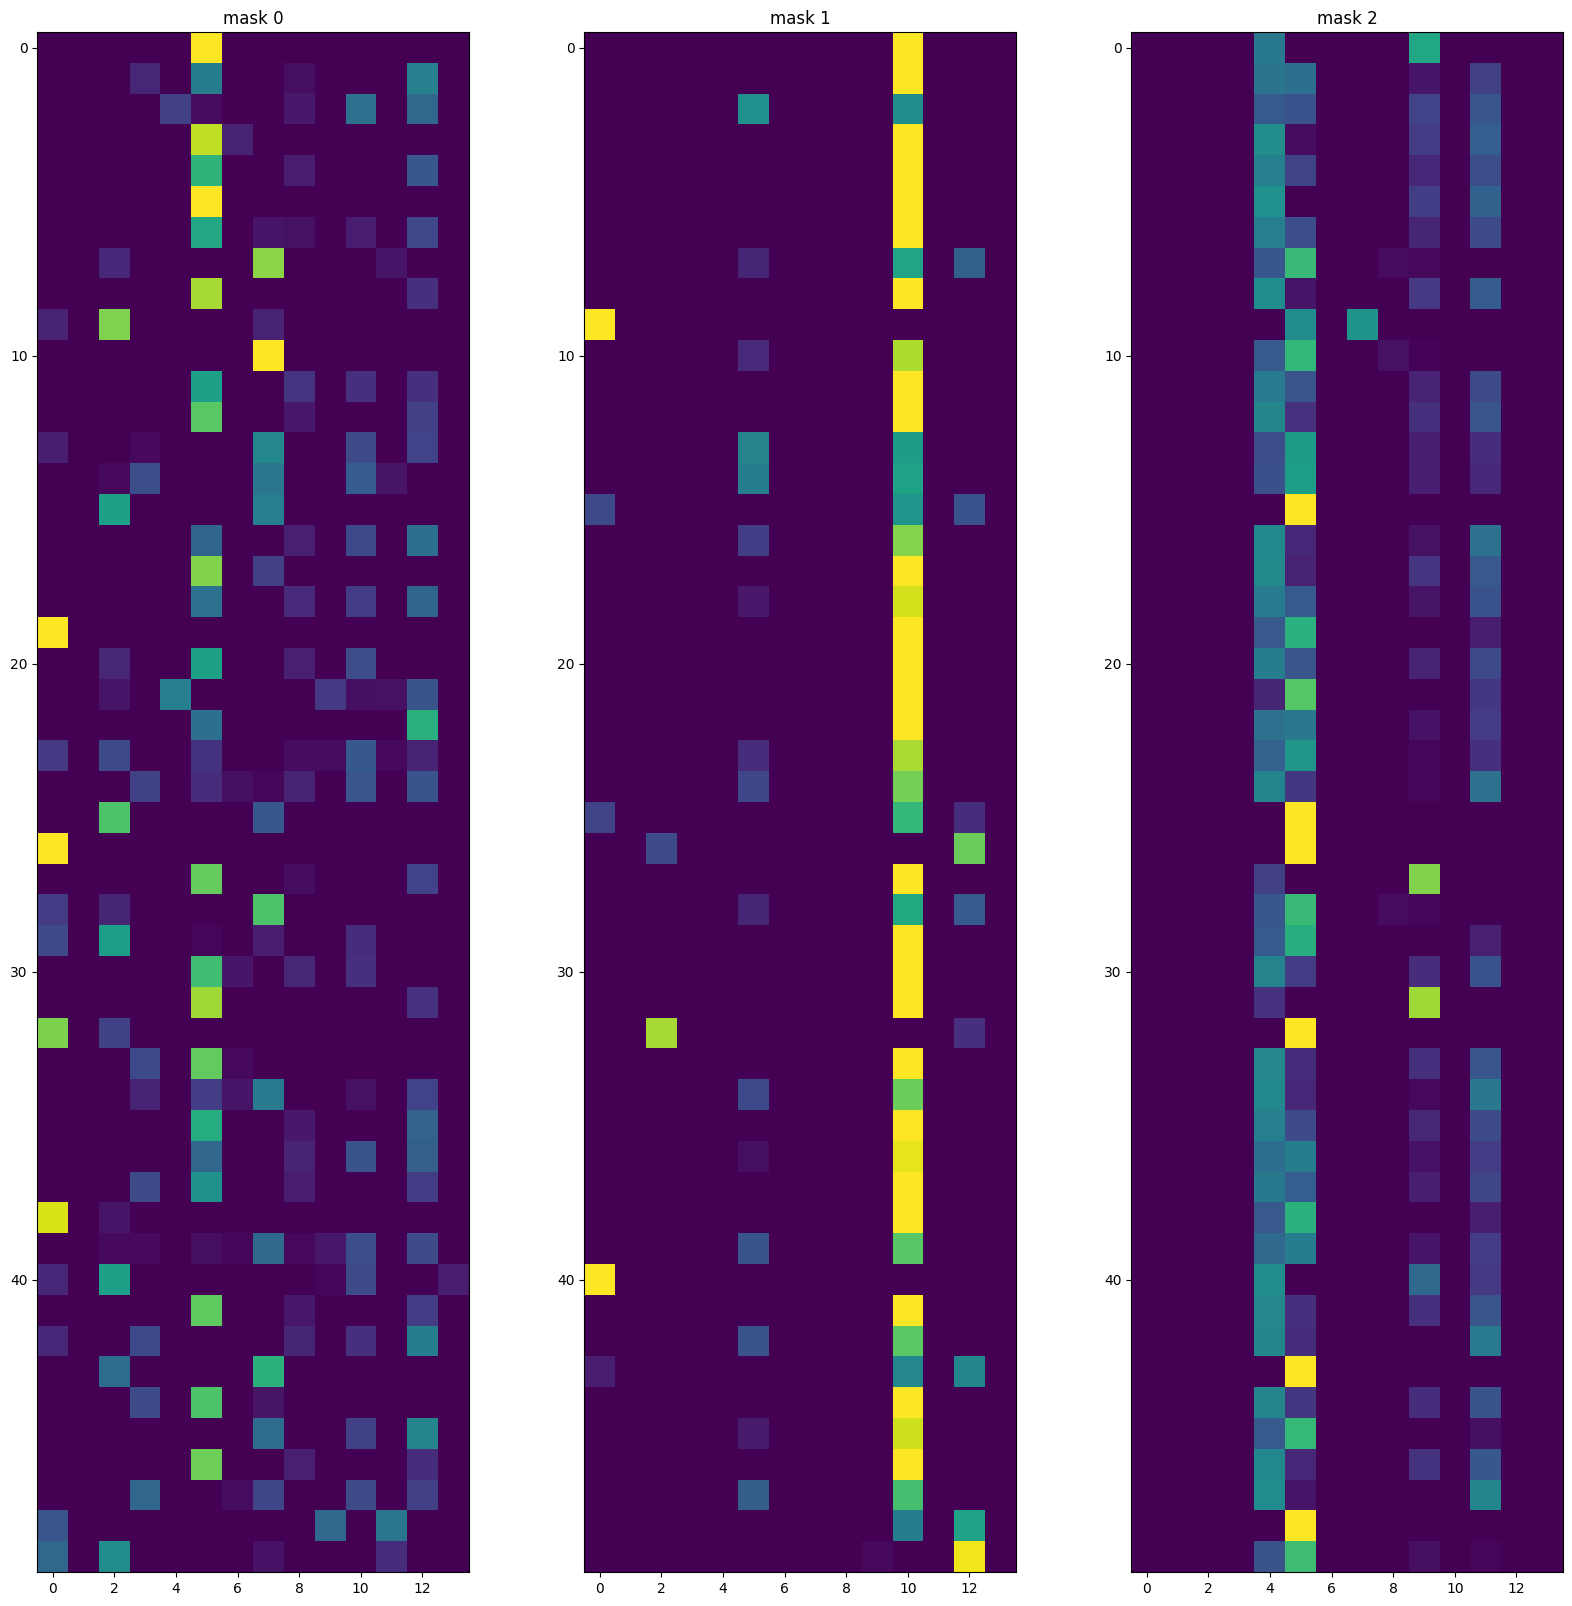

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")


# XGB

In [ ]:
from xgboost import XGBRegressor

clf_xgb = XGBRegressor(max_depth=8,
    learning_rate=0.1,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='reg:linear',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=40,
        verbose=10)

[0]	validation_0-rmse:0.46966


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-rmse:0.33042
[20]	validation_0-rmse:0.30299
[30]	validation_0-rmse:0.29676
[40]	validation_0-rmse:0.29432
[50]	validation_0-rmse:0.29357
[60]	validation_0-rmse:0.29379
[70]	validation_0-rmse:0.29397
[80]	validation_0-rmse:0.29466
[89]	validation_0-rmse:0.29509


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=0, max_depth=8,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=-1, nthread=None, num_parallel_tree=None, ...)

In [ ]:
preds = np.array(clf_xgb.predict(X_valid))
valid_auc = mean_squared_error(y_pred=preds, y_true=y_valid)
print(valid_auc)

preds = np.array(clf_xgb.predict(X_test))
test_auc = mean_squared_error(y_pred=preds, y_true=y_test)
print(test_auc)

0.08611793607844748
0.09051238654361735
